In [1]:
%matplotlib inline
import os
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import contextily as cx

In [2]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
svi_dir = os.path.join(data_dir,'SocialVulnerabilityIndex')
result_dir = os.path.join(data_dir, 'results')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')

In [3]:
svi_file = os.path.join(result_dir,'svi_qtr')
svi_gdf = gpd.read_file(svi_file)

In [6]:
svi_gdf = svi_gdf.rename(columns={'INTPTLAT':'lat', 'INTPTLON':'lon', 'GEOID':'grid_squar'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf

just_grid = deaths_gdf.loc[(deaths_gdf['year']==2000)&(deaths_gdf['quarter']==4), ['grid_squar','geometry', 'lat', 'lon']]


In [7]:
deaths_gdf = deaths_gdf.fillna(deaths_gdf.mean())
deaths_gdf = deaths_gdf.drop_duplicates(['grid_squar','year','quarter','deaths'])

In [8]:
# Make lat and lon floats
deaths_gdf.loc[:, 'lat'] = deaths_gdf.lat.astype(float)
deaths_gdf.loc[:, 'lon'] = deaths_gdf.lon.astype(float)

In [9]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [10]:
# Calculate each squares neighbors
neighbors = {}
for _, row in just_grid.iterrows():
    just_grid.loc[:,'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                         x['lon'], x['lat']),
                                                  axis=1)
    matching_neighbors = just_grid[just_grid['haversine']<8]['grid_squar'].values
    neighbors[row['grid_squar']]=matching_neighbors

In [11]:
tracts = deaths_gdf['grid_squar'].unique()
min_year = deaths_gdf.year.min()
max_year = deaths_gdf.year.max()
deaths_gdf = deaths_gdf.set_index(['grid_squar','year','quarter']).sort_index()
deaths_gdf.loc[idx[:,:,:],'self_t-1'] = deaths_gdf.loc[idx[:,:,:],'deaths'].shift(1, fill_value=0)
deaths_gdf.loc[idx[:,:,:],'delta_deaths'] = deaths_gdf.loc[idx[:,:,:],'deaths'] - deaths_gdf.loc[idx[:,:,:],'self_t-1']
for tract in tracts:
     deaths_gdf.loc[idx[tract,:,:],'neighbor_t-1']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'self_t-1'].groupby(level=['year', 'quarter']).mean().shift(1, fill_value=0).values

In [12]:
timestep = 0

for year in range(min_year, max_year+1):
    for quarter in range(1, 5):
        deaths_gdf.loc[idx[:,year, quarter], 'timestep'] = timestep
        timestep+=1

In [13]:
deaths_gdf_with_autoregressive = deaths_gdf.reset_index()

In [14]:
train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','timestep','delta_deaths']]
train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','timestep','delta_deaths']]

x_just_2019 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019)&(deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019)&(deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','timestep','delta_deaths']]
x_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
y_just_2020 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2020)&(deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','timestep','delta_deaths']]

In [15]:
def mean_log_absolute_error(y_true, y_pred):
    
    min_val = abs(min(min(y_true), min(y_pred))) + 1

    return np.average(np.abs(np.log(y_pred.values+min_val) -
                             np.log(y_true.values+min_val)), axis=0)

In [16]:
def top_X(y_true, y_pred, X=10):
    '''Makes ugly assumptions that y_true is a df with 
    GEOID and deaths columns.
    y_pred is a series with deaths as values and GEOID as index
    '''
    
    top_y_true = y_true.sort_values('delta_deaths')[-X:]
    top_predicted_geoids = y_pred.sort_values()[-X:].index
    
    y_top_true_deaths =  top_y_true['delta_deaths'].sum()
    
    y_top_predicted_deaths = y_true[y_true['grid_squar'].isin(top_predicted_geoids)]['delta_deaths'].sum()
    
    return y_top_true_deaths - y_top_predicted_deaths, y_top_predicted_deaths/y_top_true_deaths

In [17]:
mean_2019_auto_preds = deaths_gdf_with_autoregressive[
    deaths_gdf_with_autoregressive['year']==2019].groupby(['grid_squar']).sum()['self_t-1']
mean_2020_auto_preds = deaths_gdf_with_autoregressive[
    deaths_gdf_with_autoregressive['year']==2020].groupby(['grid_squar']).sum()['self_t-1']

In [18]:
mean_MAE_auto_2019 = mean_absolute_error(y_just_2019.sort_values('grid_squar').delta_deaths, mean_2019_auto_preds.sort_index())
mean_MAE_auto_2020 = mean_absolute_error(y_just_2020.sort_values('grid_squar').delta_deaths, mean_2020_auto_preds.sort_index())

mean_MLAE_auto_2019 = mean_log_absolute_error(y_just_2019.sort_values('grid_squar').delta_deaths, mean_2019_auto_preds.sort_index())
mean_MLAE_auto_2020 = mean_log_absolute_error(y_just_2020.sort_values('grid_squar').delta_deaths, mean_2020_auto_preds.sort_index())


mean_top_10_auto_2019 = top_X(y_just_2019, mean_2019_auto_preds, X=10)
mean_top_10_auto_2020 = top_X(y_just_2020, mean_2020_auto_preds, X=10)


mean_top_50_auto_2019 = top_X(y_just_2019, mean_2019_auto_preds, X=50)
mean_top_50_auto_2020 = top_X(y_just_2020, mean_2020_auto_preds, X=50)

mean_top_100_auto_2019 = top_X(y_just_2019, mean_2019_auto_preds, X=100)
mean_top_100_auto_2020 = top_X(y_just_2020, mean_2020_auto_preds, X=100)

In [17]:
print(mean_MAE_auto_2019 )
print(mean_MAE_auto_2020 )

print(mean_MLAE_auto_2019 )
print(mean_MLAE_auto_2020)

print(mean_top_10_auto_2019[0])
print(mean_top_10_auto_2020[0])
print(mean_top_50_auto_2019[0])
print(mean_top_50_auto_2020[0])
print(mean_top_100_auto_2019[0])
print(mean_top_100_auto_2020[0])
print(mean_top_10_auto_2019[1])
print(mean_top_10_auto_2020[1])
print(mean_top_50_auto_2019[1])
print(mean_top_50_auto_2020[1])
print(mean_top_100_auto_2019[1])
print(mean_top_100_auto_2020[1])

1.0938271604938272
1.2265432098765432
0.19049534714853578
0.25700782732977945
29.0
35.0
105.0
107.0
171.0
142.0
-0.07407407407407407
-0.25
-0.05
-0.0594059405940594
-0.14
0.059602649006622516


In [18]:
deaths_and_preds = y_just_2019.merge(mean_2019_auto_preds.rename('pred_deaths'),left_on='grid_squar', right_index=True)
deaths_and_preds.loc[:,'residuals'] = deaths_and_preds.delta_deaths-deaths_and_preds.pred_deaths
residual_gdf = just_grid.merge(deaths_and_preds, on='grid_squar')

#fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax = residual_gdf.plot(column='residuals', cmap='RdYlGn',ax=ax, legend=True,
                 vmin=-10, vmax=0, alpha=0.1)
plt.title(f'2019 Q1 Residuals from Guess t-1, MAE {mean_MAE_auto_2019:.2f}')
cx.add_basemap(ax)

NameError: name 'ax' is not defined

In [55]:
residual_gdf.explore()

AttributeError: 'GeoDataFrame' object has no attribute 'explore'

In [63]:
residual_gdf.crs

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
cx.add_basemap(ax,source=cx.providers.Stamen.TonerLite)

/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zi

Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/

Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/

Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/

Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/

RuntimeError: In load_glyph: Could not load glyph (error code 0x55)

<Figure size 864x576 with 1 Axes>

In [19]:
plot_gdf = gpd.GeoDataFrame(residual_gdf, crs='EPSG:4326', geometry=residual_gdf.geometry)

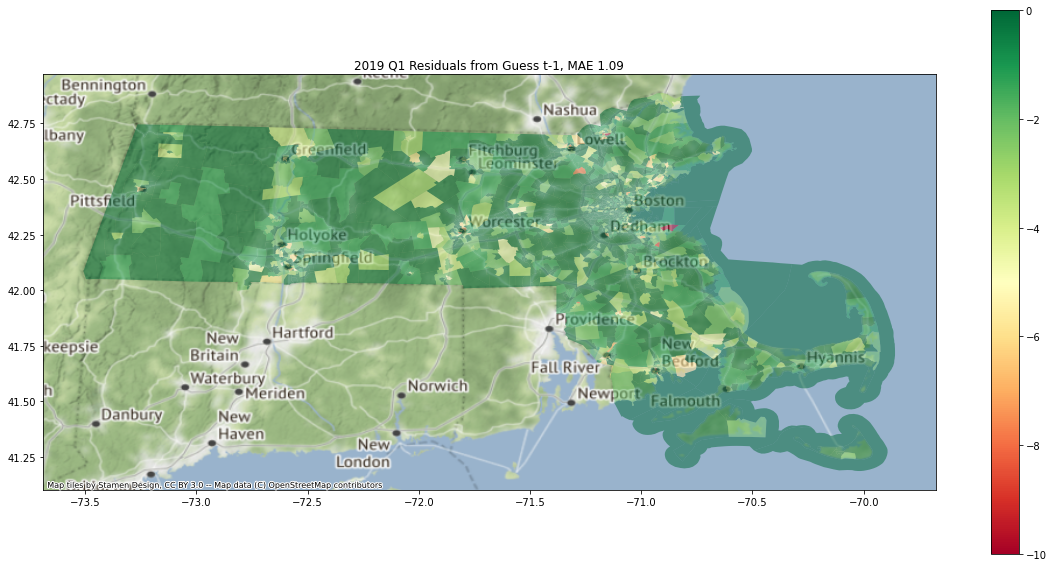

In [27]:
ax = plot_gdf.plot( figsize=(20,10),column='residuals', cmap='RdYlGn', legend=True,
                 vmin=-10, vmax=0, alpha=0.5)

plt.title(f'2019 Q1 Residuals from Guess t-1, MAE {mean_MAE_auto_2019:.2f}')
cx.add_basemap(ax, crs=plot_gdf.crs, zoom=8)

In [75]:
plot_gdf

,grid_squar,geometry,lat,lon,timestep,delta_deaths,pred_deaths,residuals
0,25017333300,"POLYGON ((-71.16139 42.47071, -71.16136 42.471...",42.470764,-71.152055,76.0,0.0,3.0,-3.0
1,25017333400,"POLYGON ((-71.14690 42.48077, -71.14673 42.480...",42.484548,-71.132032,76.0,-1.0,2.0,-3.0
2,25017333502,"POLYGON ((-71.15960 42.48482, -71.15954 42.484...",42.485040,-71.146119,76.0,0.0,0.0,0.0
3,25017354500,"POLYGON ((-71.13077 42.38261, -71.13070 42.382...",42.384745,-71.125040,76.0,0.0,0.0,0.0
4,25017354700,"POLYGON ((-71.12901 42.39007, -71.12768 42.389...",42.389581,-71.122629,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1615,25009208302,"POLYGON ((-71.01723 42.48901, -71.01705 42.489...",42.485038,-71.004081,76.0,0.0,0.0,0.0
1616,25009212101,"POLYGON ((-71.05565 42.62288, -71.05509 42.625...",42.613694,-71.005231,76.0,0.0,2.0,-2.0
1617,25009208401,"POLYGON ((-71.04695 42.48796, -71.04672 42.488...",42.487612,-71.030763,76.0,0.0,0.0,0.0
1618,25009208402,"POLYGON ((-71.05389 42.47878, -71.05373 42.479...",42.466251,-71.035971,76.0,0.0,0.0,0.0


In [76]:
ax

<AxesSubplot:>

In [19]:
median_2019_preds = train_y_through_2018.groupby('grid_squar').median()['delta_deaths']
mean_2019_preds = train_y_through_2018.groupby('grid_squar').mean()['delta_deaths']
median_2020_preds = train_y_through_2019.groupby('grid_squar').median()['delta_deaths']
mean_2020_preds = train_y_through_2019.groupby('grid_squar').mean()['delta_deaths']

In [20]:
median_MAE_2019 = mean_absolute_error(y_just_2019.sort_values('grid_squar').delta_deaths, median_2019_preds.sort_index())
median_MAE_2020 = mean_absolute_error(y_just_2020.sort_values('grid_squar').delta_deaths, median_2020_preds.sort_index())
mean_MAE_2019 = mean_absolute_error(y_just_2019.sort_values('grid_squar').delta_deaths, mean_2019_preds.sort_index())
mean_MAE_2020 = mean_absolute_error(y_just_2020.sort_values('grid_squar').delta_deaths, mean_2020_preds.sort_index())

median_MLAE_2019 = mean_log_absolute_error(y_just_2019.sort_values('grid_squar').delta_deaths, median_2019_preds.sort_index())
median_MLAE_2020 = mean_log_absolute_error(y_just_2020.sort_values('grid_squar').delta_deaths, median_2020_preds.sort_index())
mean_MLAE_2019 = mean_log_absolute_error(y_just_2019.sort_values('grid_squar').delta_deaths, mean_2019_preds.sort_index())
mean_MLAE_2020 = mean_log_absolute_error(y_just_2020.sort_values('grid_squar').delta_deaths, mean_2020_preds.sort_index())

median_top_10_2019 = top_X(y_just_2019, median_2019_preds, X=10)
median_top_10_2020 = top_X(y_just_2020, median_2020_preds, X=10)
mean_top_10_2019 = top_X(y_just_2019, mean_2019_preds, X=10)
mean_top_10_2020 = top_X(y_just_2020, mean_2020_preds, X=10)

median_top_50_2019 = top_X(y_just_2019, median_2019_preds, X=50)
median_top_50_2020 = top_X(y_just_2020, median_2020_preds, X=50)
mean_top_50_2019 = top_X(y_just_2019, mean_2019_preds, X=50)
mean_top_50_2020 = top_X(y_just_2020, mean_2020_preds, X=50)

median_top_100_2019 = top_X(y_just_2019, median_2019_preds, X=100)
median_top_100_2020 = top_X(y_just_2020, median_2020_preds, X=100)
mean_top_100_2019 = top_X(y_just_2019, mean_2019_preds, X=100)
mean_top_100_2020 = top_X(y_just_2020, mean_2020_preds, X=100)

In [21]:
print(median_MAE_2019 )
print(median_MAE_2020 )

print(median_MLAE_2019 )
print(median_MLAE_2020)

print(median_top_10_2019 [0])
print(median_top_10_2020[0])
print(median_top_50_2019[0])
print(median_top_50_2020 [0])
print(median_top_100_2019 [0])
print(median_top_100_2020[0])
print(median_top_10_2019 [1])
print(median_top_10_2020[1])
print(median_top_50_2019[1])
print(median_top_50_2020 [1])
print(median_top_100_2019 [1])
print(median_top_100_2020[1])

0.40185185185185185
0.4111111111111111
0.08375801524219426
0.10881690474324866
26.0
29.0
96.0
99.0
140.0
148.0
0.037037037037037035
-0.03571428571428571
0.04
0.019801980198019802
0.06666666666666667
0.019867549668874173


In [ ]:
deaths_gdf.mean()

In [35]:
deaths_gdf[deaths_gdf['deaths']==0]

STATEFP COUNTYFP TRACTCE     NAME  \
grid_squar  year quarter                                     
25001010100 2000 1            25      001   10100      101   
                 2            25      001   10100      101   
                 3            25      001   10100      101   
                 4            25      001   10100      101   
            2001 3            25      001   10100      101   
...                          ...      ...     ...      ...   
25027761402 2020 3            25      027  761402  7614.02   
                 4            25      027  761402  7614.02   
            2021 2            25      027  761402  7614.02   
                 3            25      027  761402  7614.02   
                 4            25      027  761402  7614.02   

                                      NAMELSAD  MTFCC FUNCSTAT     ALAND  \
grid_squar  year quarter                                                   
25001010100 2000 1            Census Tract 101  G5020        S  25046216   
                 2            Census Tract 101  G5020        S  25046216   
                 3            Census Tract 101  G5020        S  25046216   
                 4            Census Tract 101  G5020        S  25046216   
            2001 3            Census Tract 101  G5020        S  25046216   
...                                        ...    ...      ...       ...   
25027761402 2020 3        Census Tract 7614.02  G5020        S  25568170   
                 4        Census Tract 7614.02  G5020        S  25568170   
            2021 2        Census Tract 7614.02  G5020        S  25568170   
                 3        Census Tract 7614.02  G5020        S  25568170   
                 4        Census Tract 7614.02  G5020        S  25568170   

                            AWATER        lat  ...  svi_pctile         FIPS  \
grid_squar  year quarter                       ...                            
25001010100 2000 1        12765872  42.059829  ...      0.6230  25001010100   
                 2        12765872  42.059829  ...      0.6230  25001010100   
                 3        12765872  42.059829  ...      0.6230  25001010100   
                 4        12765872  42.059829  ...      0.6230  25001010100   
            2001 3        12765872  42.059829  ...      0.6230  25001010100   
...                            ...        ...  ...         ...          ...   
25027761402 2020 3          209089  42.531342  ...      0.2237         None   
                 4          209089  42.531342  ...      0.2237         None   
            2021 2          209089  42.531342  ...      0.2237         None   
                 3          209089  42.531342  ...      0.2237         None   
                 4          209089  42.531342  ...      0.2237         None   

                          ROUNDED_TR  ROUNDED__1  TRACTCE_y  \
grid_squar  year quarter                                      
25001010100 2000 1              None        None       None   
                 2              None        None       None   
                 3              None        None       None   
                 4              None        None       None   
            2001 3              None        None       None   
...                              ...         ...        ...   
25027761402 2020 3            761400      761400       None   
                 4            761400      761400       None   
            2021 2            761400      761400       None   
                 3            761400      761400       None   
                 4            761400      761400       None   

                                                                   geometry  \
grid_squar  year quarter                                                      
25001010100 2000 1        POLYGON ((-70.25001 42.06410, -70.24959 42.065...   
                 2        POLYGON ((-70.25001 42.06410, -70.24959 42.065...   
                 3        POLYGON ((-70.25001 42.06410, -70.24959

In [36]:
123763/deaths_gdf.shape[0]

0.8681467452300785